values
METFORMIN_C
1    373
0    122
Name: count, dtype: int64
values
PATGROUPFINAL_C
1    495
0    176
Name: count, dtype: int64
Epoch [50/100], Loss: 0.0054, DCor: 0.0037
Epoch [100/100], Loss: 0.0058, DCor: 0.0059


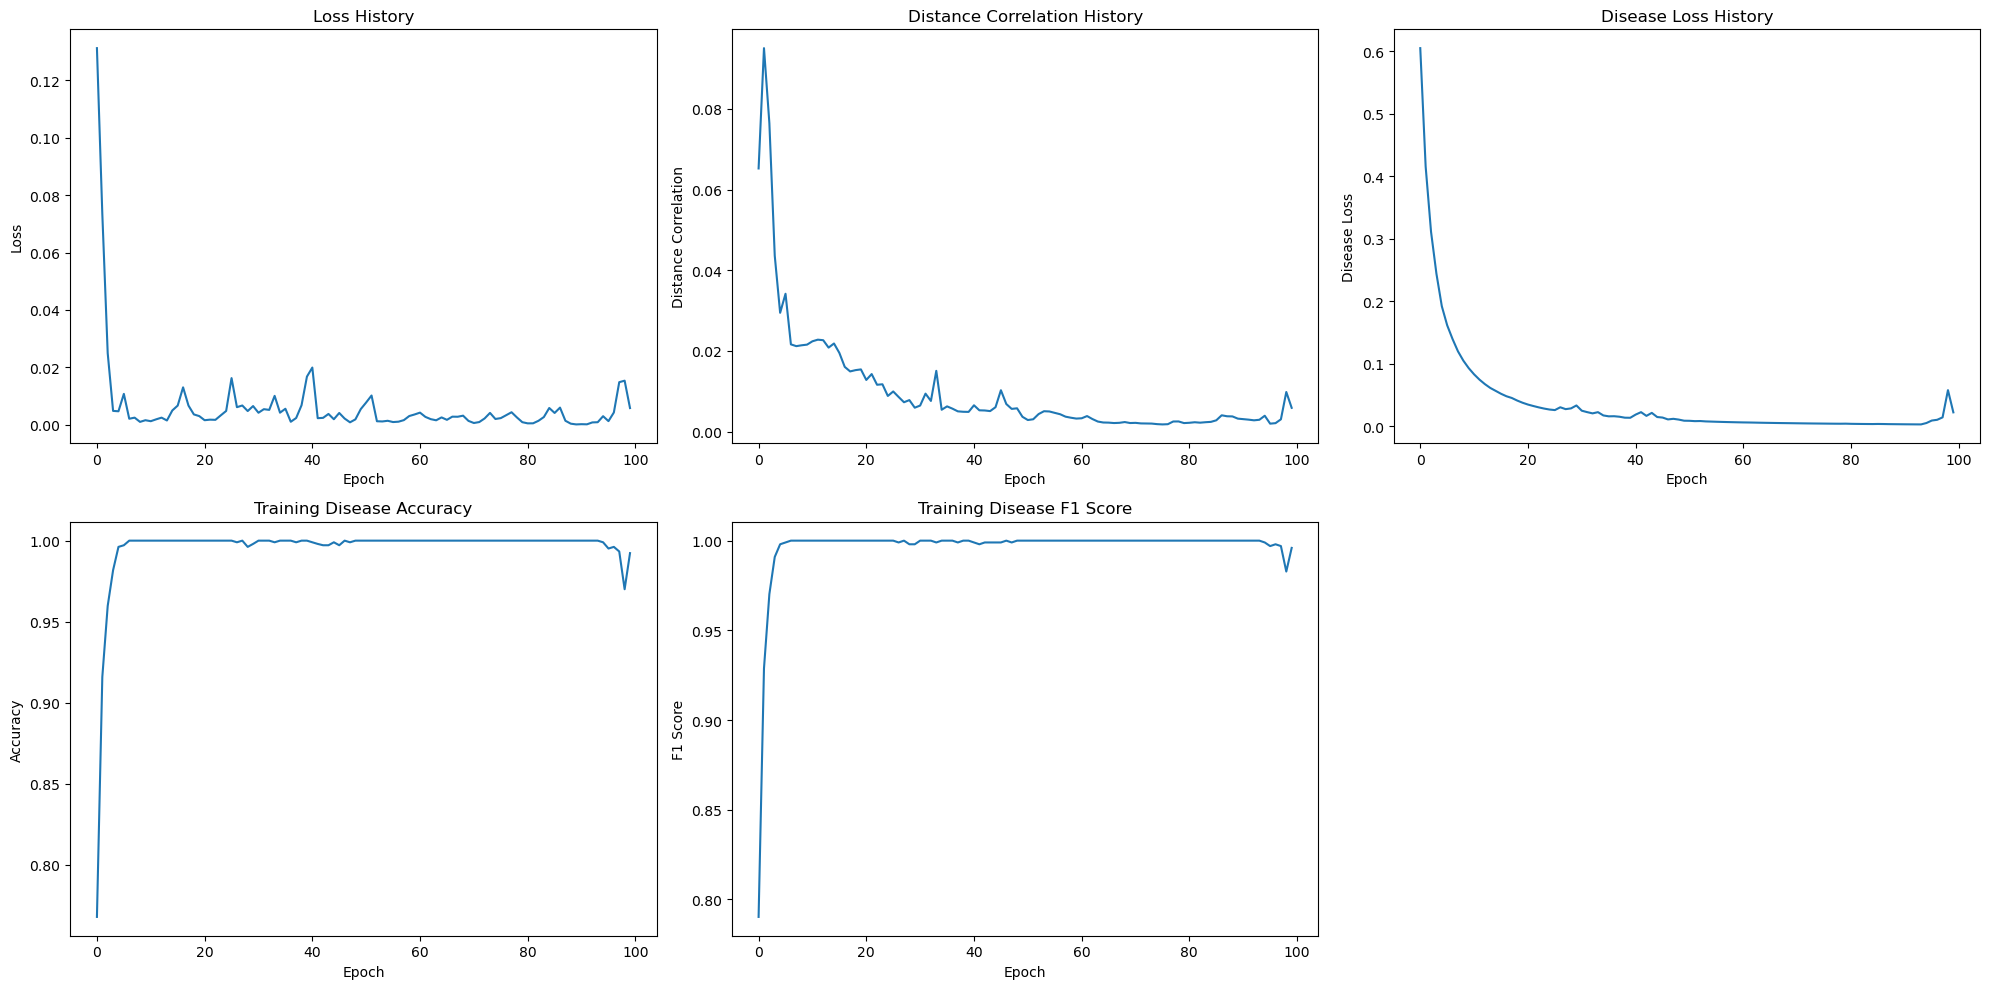

In [1]:
### data_all_loader has been added but not used yet
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import dcor
import math
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pearson Correlation Loss
class PearsonCorrelationLoss(nn.Module):
    def __init__(self):
        super(PearsonCorrelationLoss, self).__init__()

    def forward(self, pred, target):
        x = target
        y = pred
        mx = torch.mean(x)
        my = torch.mean(y)
        xm = x - mx
        ym = y - my
        r_num = torch.sum(xm * ym)
        r_den = torch.sqrt(torch.sum(xm ** 2) * torch.sum(ym ** 2)) + 1e-5
        r = r_num / r_den
        r = torch.clamp(r, min=-1.0, max=1.0)
        return r ** 2

def previous_power_of_two(x):
    """Return the largest power of two less than or equal to x."""
    return 1 << (x - 1).bit_length() - 1

class GAN(nn.Module):
    def __init__(self, input_size, latent_dim=64, num_layers=1):
        super(GAN, self).__init__()
        
        self.encoder = self._build_encoder(input_size, latent_dim, num_layers)
        self.classifier = self._build_classifier(latent_dim, num_layers)
        self.disease_classifier = self._build_classifier(latent_dim, num_layers)

    
    def _build_encoder(self, input_size, latent_dim, num_layers):
        """Build the encoder network."""
        layers = []
        first_layer = previous_power_of_two(input_size)
        layers.extend([
            nn.Linear(input_size, first_layer),
            nn.BatchNorm1d(first_layer),
            nn.ReLU()
        ])
        current_dim = first_layer
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.ReLU()
            ])
            current_dim = current_dim // 2
        layers.extend([
            nn.Linear(current_dim, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        ])
        return nn.Sequential(*layers)

    def _build_classifier(self, latent_dim, num_layers):
        """Build the disease classifier."""
        layers = []
        current_dim = latent_dim
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.Tanh()
            ])
            current_dim = current_dim // 2
        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())
        return nn.Sequential(*layers)
    

def load_and_transform_data(file_path):
    """
    Load data from CSV, apply CLR transformation, and return transformed DataFrame with 'uid'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values
    X_log = np.log(X + 1)
    X_log_df = pd.DataFrame(X_log, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]

def generate_disease_data():
    file_path = 'MetaCardis_data/train_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/train_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)
    filtered_metadata = metadata[metadata['PATGROUPFINAL_C'] == 1]
    merged_data = pd.merge(filtered_metadata, relative_abundance, on='SampleID')

    print("values")
    print(merged_data['METFORMIN_C'].value_counts())

    metadata_columns = filtered_metadata.columns.tolist()
    feature_columns = [col for col in merged_data.columns if col not in metadata_columns and col != 'SampleID']

    features = merged_data[feature_columns].values
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(merged_data['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)

    return x, y

def generate_all_data():
    file_path = 'MetaCardis_data/train_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/train_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')

    print("values")
    print(merged_data['PATGROUPFINAL_C'].value_counts())

    metadata_columns = metadata.columns.tolist()
    feature_columns = [col for col in merged_data.columns if col not in metadata_columns and col != 'SampleID']

    features = merged_data[feature_columns].values
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(merged_data['PATGROUPFINAL_C'].values, dtype=torch.float32).unsqueeze(1)

    return x, y

# New function to encapsulate class proportion and stratified batching logic
def create_stratified_dataloader(x_train, y_train, batch_size):
    # Compute class counts and proportions
    labels = y_train.squeeze()
    unique_labels = labels.unique()
    class_counts = {label.item(): (labels == label).sum().item() for label in unique_labels}
    total_samples = len(labels)
    class_proportions = {label: count / total_samples for label, count in class_counts.items()}

    # Compute samples per class per batch
    samples_per_class = {}
    remainders = {}
    total_samples_in_batch = 0

    for label, proportion in class_proportions.items():
        exact_samples = proportion * batch_size
        samples = int(math.floor(exact_samples))
        remainder = exact_samples - samples
        samples_per_class[label] = samples
        remainders[label] = remainder
        total_samples_in_batch += samples

    # Distribute remaining slots based on the largest remainders
    remaining_slots = batch_size - total_samples_in_batch
    sorted_labels = sorted(remainders.items(), key=lambda x: x[1], reverse=True)
    for i in range(remaining_slots):
        label = sorted_labels[i % len(sorted_labels)][0]
        samples_per_class[label] += 1

    # Get indices for each class and shuffle them
    class_indices = {label.item(): (labels == label).nonzero(as_tuple=True)[0] for label in unique_labels}
    for label in class_indices:
        indices = class_indices[label]
        class_indices[label] = indices[torch.randperm(len(indices))]

    # Generate stratified batches
    def stratified_batches(class_indices, samples_per_class, batch_size):
        batches = []
        class_cursors = {label: 0 for label in class_indices}
        num_samples = sum([len(indices) for indices in class_indices.values()])
        num_batches = math.ceil(num_samples / batch_size)

        for _ in range(num_batches):
            batch = []
            for label, indices in class_indices.items():
                cursor = class_cursors[label]
                samples = samples_per_class[label]
                # If we've run out of samples for this class, skip
                if cursor >= len(indices):
                    continue
                # Adjust samples if not enough samples left
                if cursor + samples > len(indices):
                    samples = len(indices) - cursor
                batch_indices = indices[cursor:cursor+samples]
                batch.extend(batch_indices.tolist())
                class_cursors[label] += samples
            # Shuffle batch indices
            if batch:
                batch = torch.tensor(batch)[torch.randperm(len(batch))].tolist()
                batches.append(batch)
        return batches

    batches = stratified_batches(class_indices, samples_per_class, batch_size)

    # Create a custom BatchSampler
    class StratifiedBatchSampler(torch.utils.data.BatchSampler):
        def __init__(self, batches):
            self.batches = batches

        def __iter__(self):
            for batch in self.batches:
                yield batch

        def __len__(self):
            return len(self.batches)

    # Create a dataset and a DataLoader with the custom BatchSampler
    dataset = TensorDataset(x_train, y_train)
    batch_sampler = StratifiedBatchSampler(batches)
    data_loader = DataLoader(dataset, batch_sampler=batch_sampler)

    return data_loader

# Training function with DataLoader
def train_model(model, criterion, optimizer, data_loader, data_all_loader, num_epochs, criterion_classifier, optimizer_classifier, criterion_disease_classifier, optimizer_disease_classifier):
    
    disease_loss_history = []
    loss_history = []
    dcor_history = []
    train_disease_accs = []
    train_disease_f1s = []
    model = model.to(device)
    criterion = criterion.to(device)
    criterion_classifier = criterion_classifier.to(device)
    criterion_disease_classifier = criterion_disease_classifier.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        
        epoch_loss = 0
        epoch_disease_loss = 0
        epoch_train_preds = []
        epoch_train_labels = []
        hidden_activations_list = []
        targets_list = []
        
        # Create iterators from both data_loaders
        data_iter = iter(data_loader)
        data_all_iter = iter(data_all_loader)
        
        while True:
            try:
                # Get the next batch from data_all_loader
                x_all_batch, y_all_batch = next(data_all_iter)
                x_all_batch, y_all_batch = x_all_batch.to(device), y_all_batch.to(device)
                
                # Try to get the next batch from data_loader
                try:
                    x_batch, y_batch = next(data_iter)
                except StopIteration:
                    # If data_loader is exhausted, re-initialize it
                    data_iter = iter(data_loader)
                    x_batch, y_batch = next(data_iter)
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                # ----------------------------
                # Train drug classification (r_loss) using x_batch, y_batch
                # ----------------------------
                # Freeze encoder parameters
                for param in model.encoder.parameters():
                    param.requires_grad = False

                encoded_features = model.encoder(x_batch)
                predicted_drug = model.classifier(encoded_features)
                r_loss = criterion_classifier(predicted_drug, y_batch)
                
                # Backward pass and optimization
                optimizer_classifier.zero_grad()
                r_loss.backward()
                optimizer_classifier.step()
                    
                # Unfreeze encoder parameters
                for param in model.encoder.parameters():
                    param.requires_grad = True

                # ----------------------------
                # Train distiller (g_loss) using x_batch, y_all_batch
                # ----------------------------
                # Freeze classifier parameters
                for param in model.classifier.parameters():
                    param.requires_grad = False
                
                encoded_features = model.encoder(x_batch)
                predicted_drug = model.classifier(encoded_features)
                g_loss = criterion(predicted_drug, y_batch)
                
                # Collect hidden activations and targets
                hidden_activations_list.append(encoded_features.detach().cpu())
                targets_list.append(y_batch.detach().cpu())
        
                # Backward pass and optimization
                optimizer.zero_grad()
                g_loss.backward()
                optimizer.step()
        
                epoch_loss += g_loss.item()
                
                # Unfreeze classifier parameters
                for param in model.classifier.parameters():
                    param.requires_grad = True

                # ----------------------------
                # Train encoder & classifier (c_loss)
                # ----------------------------

                encoded_features_all = model.encoder(x_all_batch)
                predicted_disease_all = model.disease_classifier(encoded_features_all)
                c_loss = criterion_disease_classifier(predicted_disease_all, y_all_batch)
                
                # Backward pass and optimization
                optimizer_disease_classifier.zero_grad()
                c_loss.backward()
                optimizer_disease_classifier.step()

                epoch_disease_loss += c_loss.item()

                pred_tag = (predicted_disease_all > 0.5).float()
                epoch_train_preds.append(pred_tag.cpu())
                epoch_train_labels.append(y_all_batch.cpu())

            except StopIteration:
                # When the data_all_loader iterator is exhausted, break the loop
                break

        # After the epoch, compute metrics or perform validation as needed
        avg_loss = epoch_loss / len(data_all_loader)
        avg_disease_loss = epoch_disease_loss/len(data_all_loader)
        loss_history.append(avg_loss)
        disease_loss_history.append(avg_disease_loss)

        epoch_train_preds = torch.cat(epoch_train_preds)
        epoch_train_labels = torch.cat(epoch_train_labels)

        train_disease_acc = balanced_accuracy_score(epoch_train_labels, epoch_train_preds)
        train_disease_accs.append(train_disease_acc)
        train_disease_f1 = f1_score(epoch_train_labels, epoch_train_preds)
        train_disease_f1s.append(train_disease_f1)
        
        # Concatenate hidden activations and targets
        hidden_activations_all = torch.cat(hidden_activations_list, dim=0)
        targets_all = torch.cat(targets_list, dim=0)
    
        # Compute distance correlation between hidden activations and targets
        hidden_activations_np = hidden_activations_all.numpy()
        targets_np = targets_all.numpy()
        dcor_value = dcor.distance_correlation_sqr(hidden_activations_np, targets_np)
        dcor_history.append(dcor_value)
        
        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, DCor: {dcor_value:.4f}')
    
    return loss_history, dcor_history, disease_loss_history, train_disease_accs, train_disease_f1s


# Main
if __name__ == "__main__":
    # Hyperparameters
    input_size = 654  # 654 features
    latent_dim = 32
    num_layers = 1
    learning_rate = 0.001
    num_epochs = 100
    batch_size = 64

    # Generate synthetic data with 654 features and imbalanced labels
    x_train, y_train = generate_disease_data()
    x_all_train, y_all_train = generate_all_data()

    # Create stratified DataLoader
    data_loader = create_stratified_dataloader(x_train, y_train, batch_size)
    data_all_loader = create_stratified_dataloader(x_all_train, y_all_train, batch_size)

    # Define model, loss, and optimizer
    model = GAN(input_size, latent_dim=latent_dim, num_layers=num_layers).to(device)
    criterion = PearsonCorrelationLoss().to(device)  # Use correlation loss
    optimizer = optim.Adam(model.encoder.parameters(), lr=learning_rate)
    criterion_classifier = nn.BCELoss().to(device)  # Use binary cross-entropy loss for classification
    optimizer_classifier = optim.Adam(model.classifier.parameters(), lr=learning_rate)
    criterion_disease_classifier = nn.BCELoss().to(device)
    optimizer_disease_classifier = optim.Adam(list(model.encoder.parameters()) + list(model.disease_classifier.parameters()), lr=learning_rate)

    # Move model and criteria to device
    model = model.to(device)
    criterion = criterion.to(device)
    criterion_classifier = criterion_classifier.to(device)
    criterion_disease_classifier = criterion_disease_classifier.to(device)

    # Train the model
loss_history, dcor_history, disease_loss_history, train_disease_accs, train_disease_f1s = train_model(
    model, criterion, optimizer, data_loader, data_all_loader, num_epochs, 
    criterion_classifier, optimizer_classifier, criterion_disease_classifier, optimizer_disease_classifier
)

# Plot the loss history, distance correlation history, disease loss history, training accuracy, and F1 score
plt.figure(figsize=(20, 10))

plt.subplot(2, 3, 1)
plt.plot(loss_history)
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(2, 3, 2)
plt.plot(dcor_history)
plt.title("Distance Correlation History")
plt.xlabel("Epoch")
plt.ylabel("Distance Correlation")

plt.subplot(2, 3, 3)
plt.plot(disease_loss_history)
plt.title("Disease Loss History")
plt.xlabel("Epoch")
plt.ylabel("Disease Loss")

plt.subplot(2, 3, 4)
plt.plot(train_disease_accs)
plt.title("Training Disease Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.subplot(2, 3, 5)
plt.plot(train_disease_f1s)
plt.title("Training Disease F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")

plt.tight_layout()
plt.show()



values
METFORMIN_C
1    373
0    122
Name: count, dtype: int64
values
PATGROUPFINAL_C
1    495
0    176
Name: count, dtype: int64
Test values
METFORMIN_C
1    27
0    17
Name: count, dtype: int64
Test values
PATGROUPFINAL_C
0    99
1    44
Name: count, dtype: int64
Epoch [50/200], Test Loss: 0.5467, Test Acc: 0.8068, Test F1: 0.7216
Epoch [100/200], Test Loss: 0.6739, Test Acc: 0.8018, Test F1: 0.7143
Epoch [150/200], Test Loss: 0.7621, Test Acc: 0.7967, Test F1: 0.7071
Epoch [200/200], Test Loss: 0.8326, Test Acc: 0.7967, Test F1: 0.7071


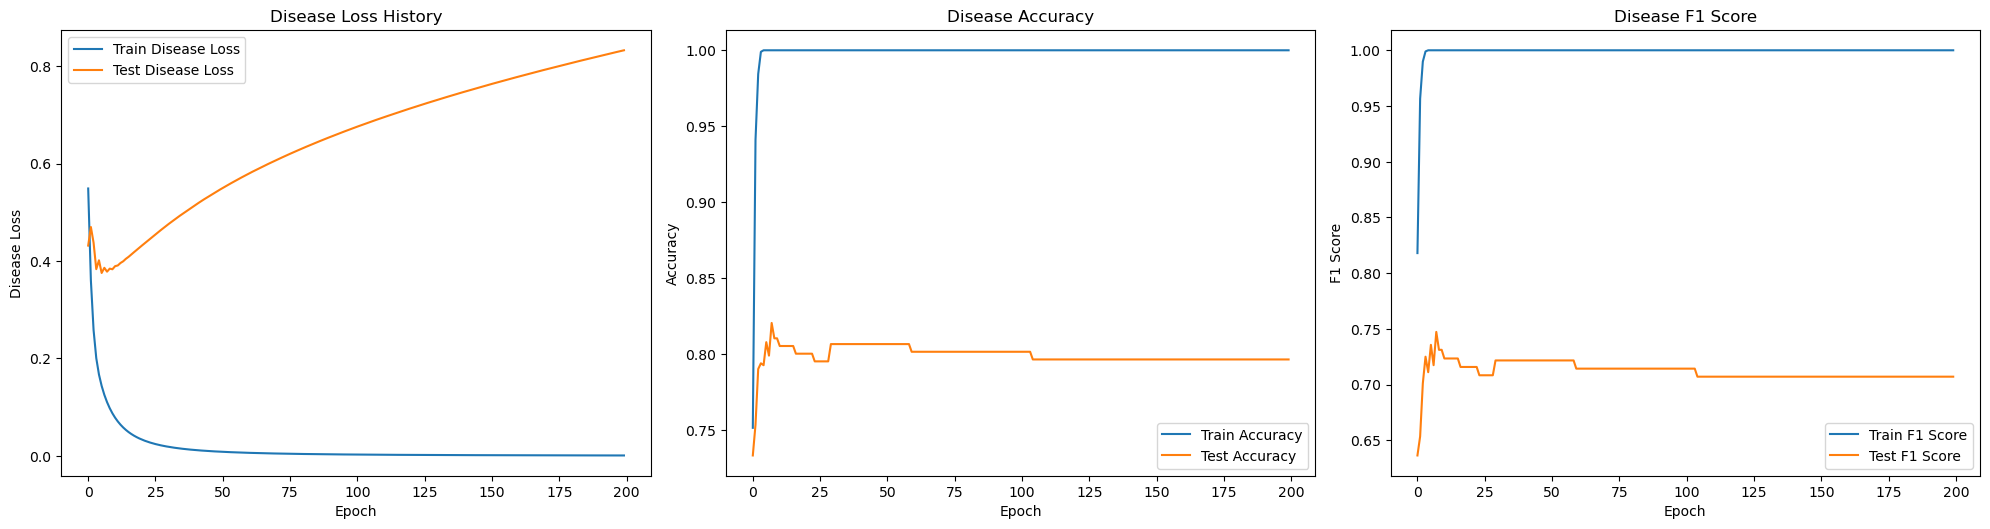

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import dcor
import math
from sklearn.metrics import balanced_accuracy_score, f1_score

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pearson Correlation Loss
class PearsonCorrelationLoss(nn.Module):
    def __init__(self):
        super(PearsonCorrelationLoss, self).__init__()

    def forward(self, pred, target):
        x = target
        y = pred
        mx = torch.mean(x)
        my = torch.mean(y)
        xm = x - mx
        ym = y - my
        r_num = torch.sum(xm * ym)
        r_den = torch.sqrt(torch.sum(xm ** 2) * torch.sum(ym ** 2)) + 1e-5
        r = r_num / r_den
        r = torch.clamp(r, min=-1.0, max=1.0)
        return r ** 2

def previous_power_of_two(x):
    """Return the largest power of two less than or equal to x."""
    return 1 << (x - 1).bit_length() - 1

class GAN(nn.Module):
    def __init__(self, input_size, latent_dim=64, num_layers=1):
        super(GAN, self).__init__()
        
        self.encoder = self._build_encoder(input_size, latent_dim, num_layers)
        self.classifier = self._build_classifier(latent_dim, num_layers)
        self.disease_classifier = self._build_classifier(latent_dim, num_layers)

    
    def _build_encoder(self, input_size, latent_dim, num_layers):
        """Build the encoder network."""
        layers = []
        first_layer = previous_power_of_two(input_size)
        layers.extend([
            nn.Linear(input_size, first_layer),
            nn.BatchNorm1d(first_layer),
            nn.ReLU()
        ])
        current_dim = first_layer
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.ReLU()
            ])
            current_dim = current_dim // 2
        layers.extend([
            nn.Linear(current_dim, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        ])
        return nn.Sequential(*layers)

    def _build_classifier(self, latent_dim, num_layers):
        """Build the disease classifier."""
        layers = []
        current_dim = latent_dim
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.Tanh()
            ])
            current_dim = current_dim // 2
        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())
        return nn.Sequential(*layers)
    

def load_and_transform_data(file_path):
    """
    Load data from CSV, apply CLR transformation, and return transformed DataFrame with 'uid'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values
    X_log = np.log(X + 1)
    X_log_df = pd.DataFrame(X_log, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]

def generate_disease_data():
    file_path = 'MetaCardis_data/train_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/train_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)
    filtered_metadata = metadata[metadata['PATGROUPFINAL_C'] == 1]
    merged_data = pd.merge(filtered_metadata, relative_abundance, on='SampleID')

    print("values")
    print(merged_data['METFORMIN_C'].value_counts())

    metadata_columns = filtered_metadata.columns.tolist()
    feature_columns = [col for col in merged_data.columns if col not in metadata_columns and col != 'SampleID']

    features = merged_data[feature_columns].values
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(merged_data['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)

    return x, y

def generate_all_data():
    file_path = 'MetaCardis_data/train_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/train_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')

    print("values")
    print(merged_data['PATGROUPFINAL_C'].value_counts())

    metadata_columns = metadata.columns.tolist()
    feature_columns = [col for col in merged_data.columns if col not in metadata_columns and col != 'SampleID']

    features = merged_data[feature_columns].values
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(merged_data['PATGROUPFINAL_C'].values, dtype=torch.float32).unsqueeze(1)

    return x, y

def generate_test_disease_data():
    file_path = 'MetaCardis_data/test_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/test_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)
    filtered_metadata = metadata[metadata['PATGROUPFINAL_C'] == 1]
    merged_data = pd.merge(filtered_metadata, relative_abundance, on='SampleID')

    print("Test values")
    print(merged_data['METFORMIN_C'].value_counts())

    metadata_columns = filtered_metadata.columns.tolist()
    feature_columns = [col for col in merged_data.columns if col not in metadata_columns and col != 'SampleID']

    features = merged_data[feature_columns].values
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(merged_data['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)

    return x, y

def generate_test_all_data():
    file_path = 'MetaCardis_data/test_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/test_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')

    print("Test values")
    print(merged_data['PATGROUPFINAL_C'].value_counts())

    metadata_columns = metadata.columns.tolist()
    feature_columns = [col for col in merged_data.columns if col not in metadata_columns and col != 'SampleID']

    features = merged_data[feature_columns].values
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(merged_data['PATGROUPFINAL_C'].values, dtype=torch.float32).unsqueeze(1)

    return x, y

# New function to encapsulate class proportion and stratified batching logic
def create_stratified_dataloader(x_train, y_train, batch_size):
    # Compute class counts and proportions
    labels = y_train.squeeze()
    unique_labels = labels.unique()
    class_counts = {label.item(): (labels == label).sum().item() for label in unique_labels}
    total_samples = len(labels)
    class_proportions = {label: count / total_samples for label, count in class_counts.items()}

    # Compute samples per class per batch
    samples_per_class = {}
    remainders = {}
    total_samples_in_batch = 0

    for label, proportion in class_proportions.items():
        exact_samples = proportion * batch_size
        samples = int(math.floor(exact_samples))
        remainder = exact_samples - samples
        samples_per_class[label] = samples
        remainders[label] = remainder
        total_samples_in_batch += samples

    # Distribute remaining slots based on the largest remainders
    remaining_slots = batch_size - total_samples_in_batch
    sorted_labels = sorted(remainders.items(), key=lambda x: x[1], reverse=True)
    for i in range(remaining_slots):
        label = sorted_labels[i % len(sorted_labels)][0]
        samples_per_class[label] += 1

    # Get indices for each class and shuffle them
    class_indices = {label.item(): (labels == label).nonzero(as_tuple=True)[0] for label in unique_labels}
    for label in class_indices:
        indices = class_indices[label]
        class_indices[label] = indices[torch.randperm(len(indices))]

    # Generate stratified batches
    def stratified_batches(class_indices, samples_per_class, batch_size):
        batches = []
        class_cursors = {label: 0 for label in class_indices}
        num_samples = sum([len(indices) for indices in class_indices.values()])
        num_batches = math.ceil(num_samples / batch_size)

        for _ in range(num_batches):
            batch = []
            for label, indices in class_indices.items():
                cursor = class_cursors[label]
                samples = samples_per_class[label]
                # If we've run out of samples for this class, skip
                if cursor >= len(indices):
                    continue
                # Adjust samples if not enough samples left
                if cursor + samples > len(indices):
                    samples = len(indices) - cursor
                batch_indices = indices[cursor:cursor+samples]
                batch.extend(batch_indices.tolist())
                class_cursors[label] += samples
            # Shuffle batch indices
            if batch:
                batch = torch.tensor(batch)[torch.randperm(len(batch))].tolist()
                batches.append(batch)
        return batches

    batches = stratified_batches(class_indices, samples_per_class, batch_size)

    # Create a custom BatchSampler
    class StratifiedBatchSampler(torch.utils.data.BatchSampler):
        def __init__(self, batches):
            self.batches = batches

        def __iter__(self):
            for batch in self.batches:
                yield batch

        def __len__(self):
            return len(self.batches)

    # Create a dataset and a DataLoader with the custom BatchSampler
    dataset = TensorDataset(x_train, y_train)
    batch_sampler = StratifiedBatchSampler(batches)
    data_loader = DataLoader(dataset, batch_sampler=batch_sampler)

    return data_loader

# Training function with DataLoader
def train_model(model, criterion, optimizer, data_loader, data_all_loader, test_data_all_loader, num_epochs, criterion_classifier, optimizer_classifier, criterion_disease_classifier, optimizer_disease_classifier):
    
    disease_loss_history = []
    loss_history = []
    dcor_history = []
    train_disease_accs = []
    train_disease_f1s = []
    test_disease_loss_history = []
    test_disease_accs = []
    test_disease_f1s = []
    model = model.to(device)
    criterion = criterion.to(device)
    criterion_classifier = criterion_classifier.to(device)
    criterion_disease_classifier = criterion_disease_classifier.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        
        epoch_loss = 0
        epoch_disease_loss = 0
        epoch_train_preds = []
        epoch_train_labels = []
        hidden_activations_list = []
        targets_list = []
        
        # Create iterators from both data_loaders
        data_iter = iter(data_loader)
        data_all_iter = iter(data_all_loader)
        
        while True:
            try:
                # Get the next batch from data_all_loader
                x_all_batch, y_all_batch = next(data_all_iter)
                x_all_batch, y_all_batch = x_all_batch.to(device), y_all_batch.to(device)
                
                # Try to get the next batch from data_loader
                try:
                    x_batch, y_batch = next(data_iter)
                except StopIteration:
                    # If data_loader is exhausted, re-initialize it
                    data_iter = iter(data_loader)
                    x_batch, y_batch = next(data_iter)
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                # ----------------------------
                # Train encoder & classifier (c_loss)
                # ----------------------------

                encoded_features_all = model.encoder(x_all_batch)
                predicted_disease_all = model.disease_classifier(encoded_features_all)
                c_loss = criterion_disease_classifier(predicted_disease_all, y_all_batch)
                
                # Backward pass and optimization
                optimizer_disease_classifier.zero_grad()
                c_loss.backward()
                optimizer_disease_classifier.step()

                epoch_disease_loss += c_loss.item()

                pred_tag = (predicted_disease_all > 0.5).float()
                epoch_train_preds.append(pred_tag.cpu())
                epoch_train_labels.append(y_all_batch.cpu())

            except StopIteration:
                # When the data_all_loader iterator is exhausted, break the loop
                break

        # After the epoch, compute metrics or perform validation as needed
        avg_disease_loss = epoch_disease_loss / len(data_all_loader)
        disease_loss_history.append(avg_disease_loss)

        epoch_train_preds = torch.cat(epoch_train_preds)
        epoch_train_labels = torch.cat(epoch_train_labels)

        train_disease_acc = balanced_accuracy_score(epoch_train_labels, epoch_train_preds)
        train_disease_accs.append(train_disease_acc)
        train_disease_f1 = f1_score(epoch_train_labels, epoch_train_preds)
        train_disease_f1s.append(train_disease_f1)
        
        
        # Evaluate on test data
        model.eval()
        with torch.no_grad():
            test_epoch_disease_loss = 0
            test_epoch_preds = []
            test_epoch_labels = []

            for x_test_batch, y_test_batch in test_data_all_loader:
                x_test_batch, y_test_batch = x_test_batch.to(device), y_test_batch.to(device)
                encoded_features_test = model.encoder(x_test_batch)
                predicted_disease_test = model.disease_classifier(encoded_features_test)
                test_c_loss = criterion_disease_classifier(predicted_disease_test, y_test_batch)
                test_epoch_disease_loss += test_c_loss.item()

                pred_tag = (predicted_disease_test > 0.5).float()
                test_epoch_preds.append(pred_tag.cpu())
                test_epoch_labels.append(y_test_batch.cpu())

            # Compute average test disease loss
            avg_test_disease_loss = test_epoch_disease_loss / len(test_data_all_loader)
            test_disease_loss_history.append(avg_test_disease_loss)

            test_epoch_preds = torch.cat(test_epoch_preds)
            test_epoch_labels = torch.cat(test_epoch_labels)

            test_disease_acc = balanced_accuracy_score(test_epoch_labels, test_epoch_preds)
            test_disease_accs.append(test_disease_acc)
            test_disease_f1 = f1_score(test_epoch_labels, test_epoch_preds)
            test_disease_f1s.append(test_disease_f1)

        model.train()
        
        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_test_disease_loss:.4f}, Test Acc: {test_disease_acc:.4f}, Test F1: {test_disease_f1:.4f}')
    
    return disease_loss_history, train_disease_accs, train_disease_f1s, test_disease_loss_history, test_disease_accs, test_disease_f1s


# Main
if __name__ == "__main__":
    # Hyperparameters
    input_size = 654  # 654 features
    latent_dim = 32
    num_layers = 1
    learning_rate = 0.001
    num_epochs = 200
    batch_size = 64

    # Generate synthetic data with 654 features and imbalanced labels
    x_train, y_train = generate_disease_data()
    x_all_train, y_all_train = generate_all_data()

    # Generate test data
    x_test, y_test = generate_test_disease_data()
    x_all_test, y_all_test = generate_test_all_data()

    # Create stratified DataLoaders
    data_loader = create_stratified_dataloader(x_train, y_train, batch_size)
    data_all_loader = create_stratified_dataloader(x_all_train, y_all_train, batch_size)
    test_data_loader = create_stratified_dataloader(x_test, y_test, batch_size)
    test_data_all_loader = create_stratified_dataloader(x_all_test, y_all_test, batch_size)

    # Define model, loss, and optimizer
    model = GAN(input_size, latent_dim=latent_dim, num_layers=num_layers).to(device)
    criterion = PearsonCorrelationLoss().to(device)  # Use correlation loss
    optimizer = optim.Adam(model.encoder.parameters(), lr=learning_rate)
    criterion_classifier = nn.BCELoss().to(device)  # Use binary cross-entropy loss for classification
    optimizer_classifier = optim.Adam(model.classifier.parameters(), lr=learning_rate)
    criterion_disease_classifier = nn.BCELoss().to(device)
    optimizer_disease_classifier = optim.Adam(list(model.encoder.parameters()) + list(model.disease_classifier.parameters()), lr=learning_rate)

    # Move model and criteria to device
    model = model.to(device)
    criterion = criterion.to(device)
    criterion_classifier = criterion_classifier.to(device)
    criterion_disease_classifier = criterion_disease_classifier.to(device)

    # Train the model
    disease_loss_history, train_disease_accs, train_disease_f1s, test_disease_loss_history, test_disease_accs, test_disease_f1s = train_model(
        model, criterion, optimizer, data_loader, data_all_loader, test_data_all_loader, num_epochs, 
        criterion_classifier, optimizer_classifier, criterion_disease_classifier, optimizer_disease_classifier
    )

    # Plot the loss history, distance correlation history, disease loss history, training and test accuracy, and F1 score
    plt.figure(figsize=(20, 10))


    plt.subplot(2, 3, 1)
    plt.plot(disease_loss_history, label='Train Disease Loss')
    plt.plot(test_disease_loss_history, label='Test Disease Loss')
    plt.title("Disease Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Disease Loss")
    plt.legend()

    plt.subplot(2, 3, 2)
    plt.plot(train_disease_accs, label='Train Accuracy')
    plt.plot(test_disease_accs, label='Test Accuracy')
    plt.title("Disease Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.plot(train_disease_f1s, label='Train F1 Score')
    plt.plot(test_disease_f1s, label='Test F1 Score')
    plt.title("Disease F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()

    plt.tight_layout()
    plt.show()


values
METFORMIN_C
1    373
0    122
Name: count, dtype: int64
values
PATGROUPFINAL_C
1    495
0    176
Name: count, dtype: int64
Test values
METFORMIN_C
1    27
0    17
Name: count, dtype: int64
Test values
PATGROUPFINAL_C
0    99
1    44
Name: count, dtype: int64
pred
tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
 

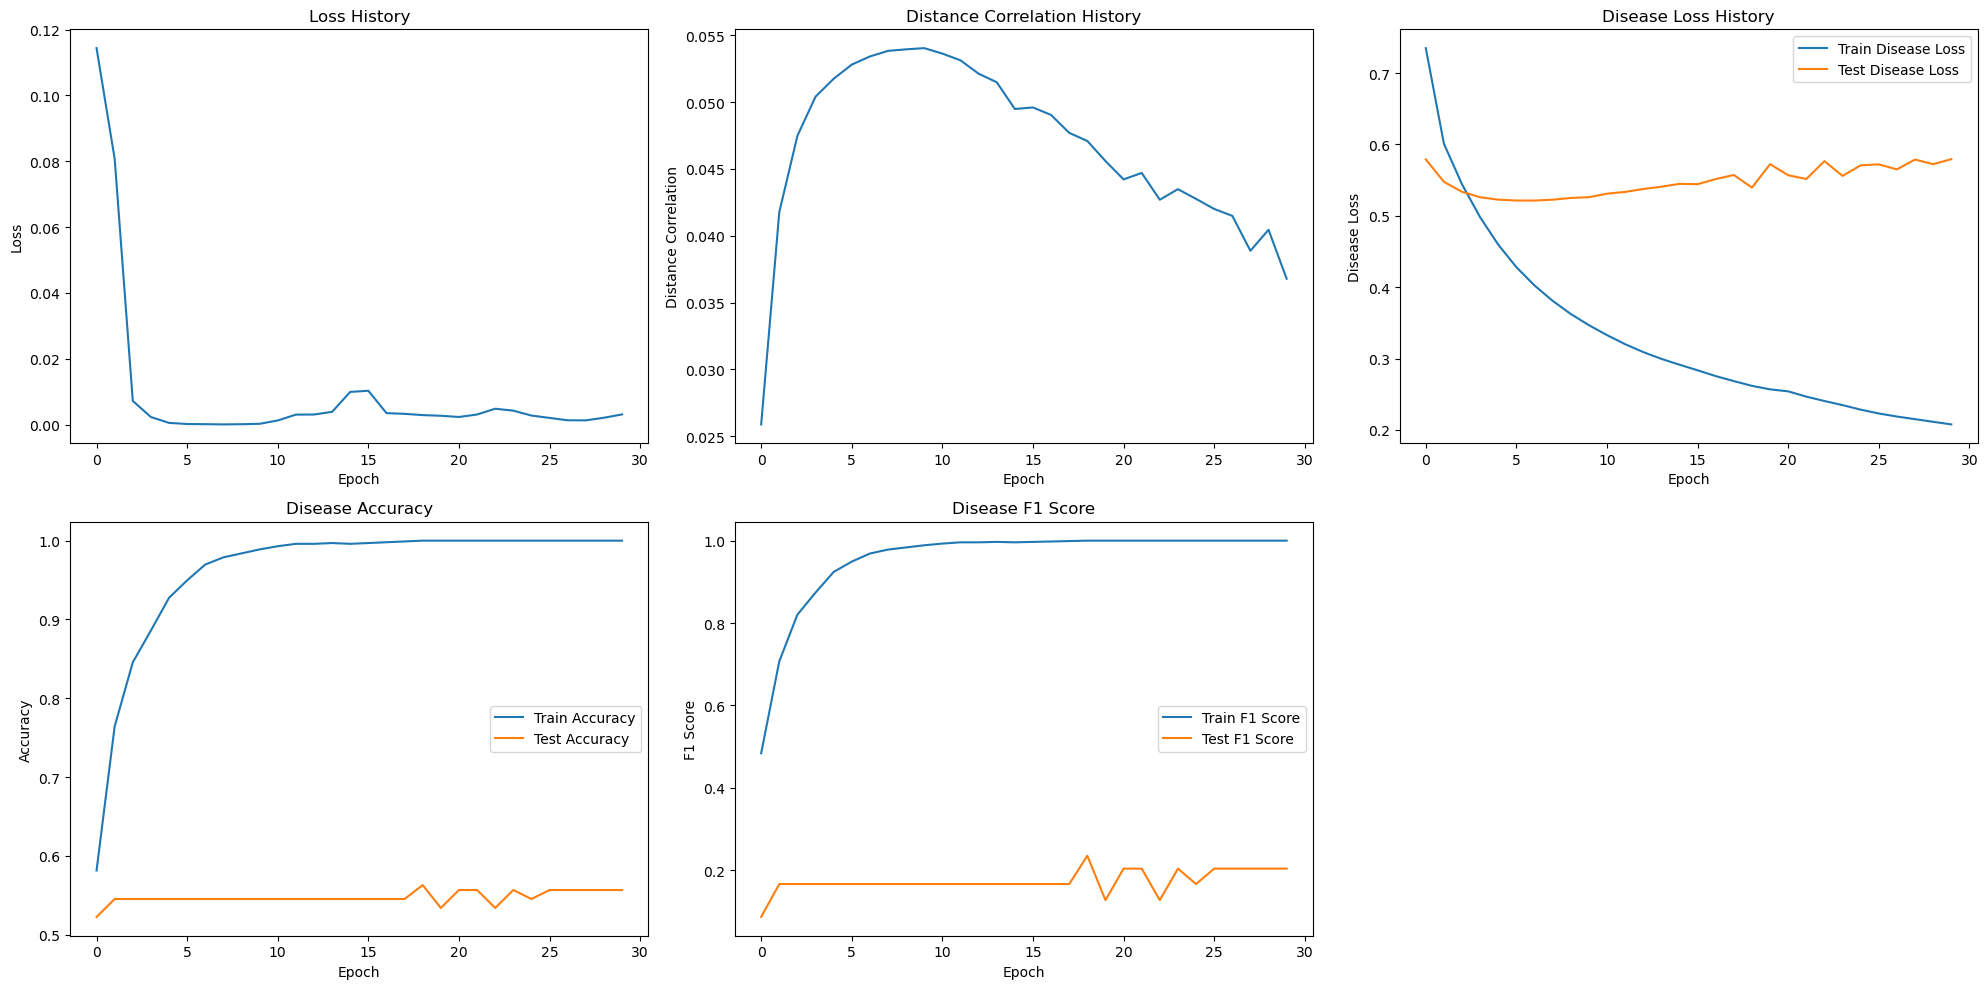

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import dcor
import math
from sklearn.metrics import balanced_accuracy_score, f1_score

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pearson Correlation Loss
class PearsonCorrelationLoss(nn.Module):
    def __init__(self):
        super(PearsonCorrelationLoss, self).__init__()

    def forward(self, pred, target):
        x = target
        y = pred
        mx = torch.mean(x)
        my = torch.mean(y)
        xm = x - mx
        ym = y - my
        r_num = torch.sum(xm * ym)
        r_den = torch.sqrt(torch.sum(xm ** 2) * torch.sum(ym ** 2)) + 1e-5
        r = r_num / r_den
        r = torch.clamp(r, min=-1.0, max=1.0)
        return r ** 2

def previous_power_of_two(x):
    """Return the largest power of two less than or equal to x."""
    return 1 << (x - 1).bit_length() - 1

class GAN(nn.Module):
    def __init__(self, input_size, latent_dim=64, num_layers=1):
        super(GAN, self).__init__()
        
        self.encoder = self._build_encoder(input_size, latent_dim, num_layers)
        self.classifier = self._build_classifier(latent_dim, num_layers)
        self.disease_classifier = self._build_classifier(latent_dim, num_layers)

    
    def _build_encoder(self, input_size, latent_dim, num_layers):
        """Build the encoder network."""
        layers = []
        first_layer = previous_power_of_two(input_size)
        layers.extend([
            nn.Linear(input_size, first_layer),
            nn.BatchNorm1d(first_layer),
            nn.ReLU()
        ])
        current_dim = first_layer
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.ReLU()
            ])
            current_dim = current_dim // 2
        layers.extend([
            nn.Linear(current_dim, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        ])
        return nn.Sequential(*layers)

    def _build_classifier(self, latent_dim, num_layers):
        """Build the disease classifier."""
        layers = []
        current_dim = latent_dim
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.Tanh()
            ])
            current_dim = current_dim // 2
        layers.append(nn.Linear(current_dim, 1))
        layers.append(nn.Sigmoid())
        return nn.Sequential(*layers)
    

def load_and_transform_data(file_path):
    """
    Load data from CSV, apply CLR transformation, and return transformed DataFrame with 'uid'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values
    X_log = np.log(X + 1)
    X_log_df = pd.DataFrame(X_log, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]

def generate_disease_data():
    file_path = 'MetaCardis_data/train_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/train_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)
    filtered_metadata = metadata[metadata['PATGROUPFINAL_C'] == 1]
    merged_data = pd.merge(filtered_metadata, relative_abundance, on='SampleID')

    print("values")
    print(merged_data['METFORMIN_C'].value_counts())

    metadata_columns = filtered_metadata.columns.tolist()
    feature_columns = [col for col in merged_data.columns if col not in metadata_columns and col != 'SampleID']

    features = merged_data[feature_columns].values
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(merged_data['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)

    return x, y

def generate_all_data():
    file_path = 'MetaCardis_data/train_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/train_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')

    print("values")
    print(merged_data['PATGROUPFINAL_C'].value_counts())

    metadata_columns = metadata.columns.tolist()
    feature_columns = [col for col in merged_data.columns if col not in metadata_columns and col != 'SampleID']

    features = merged_data[feature_columns].values
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(merged_data['PATGROUPFINAL_C'].values, dtype=torch.float32).unsqueeze(1)

    return x, y

def generate_test_disease_data():
    file_path = 'MetaCardis_data/test_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/test_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)
    filtered_metadata = metadata[metadata['PATGROUPFINAL_C'] == 1]
    merged_data = pd.merge(filtered_metadata, relative_abundance, on='SampleID')

    print("Test values")
    print(merged_data['METFORMIN_C'].value_counts())

    metadata_columns = filtered_metadata.columns.tolist()
    feature_columns = [col for col in merged_data.columns if col not in metadata_columns and col != 'SampleID']

    features = merged_data[feature_columns].values
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(merged_data['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)

    return x, y

def generate_test_all_data():
    file_path = 'MetaCardis_data/test_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/test_T2D_metadata.csv'
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')

    print("Test values")
    print(merged_data['PATGROUPFINAL_C'].value_counts())

    metadata_columns = metadata.columns.tolist()
    feature_columns = [col for col in merged_data.columns if col not in metadata_columns and col != 'SampleID']

    features = merged_data[feature_columns].values
    x = torch.tensor(features, dtype=torch.float32)
    y = torch.tensor(merged_data['PATGROUPFINAL_C'].values, dtype=torch.float32).unsqueeze(1)

    return x, y

# New function to encapsulate class proportion and stratified batching logic
def create_stratified_dataloader(x_train, y_train, batch_size):
    # Compute class counts and proportions
    labels = y_train.squeeze()
    unique_labels = labels.unique()
    class_counts = {label.item(): (labels == label).sum().item() for label in unique_labels}
    total_samples = len(labels)
    class_proportions = {label: count / total_samples for label, count in class_counts.items()}

    # Compute samples per class per batch
    samples_per_class = {}
    remainders = {}
    total_samples_in_batch = 0

    for label, proportion in class_proportions.items():
        exact_samples = proportion * batch_size
        samples = int(math.floor(exact_samples))
        remainder = exact_samples - samples
        samples_per_class[label] = samples
        remainders[label] = remainder
        total_samples_in_batch += samples

    # Distribute remaining slots based on the largest remainders
    remaining_slots = batch_size - total_samples_in_batch
    sorted_labels = sorted(remainders.items(), key=lambda x: x[1], reverse=True)
    for i in range(remaining_slots):
        label = sorted_labels[i % len(sorted_labels)][0]
        samples_per_class[label] += 1

    # Get indices for each class and shuffle them
    class_indices = {label.item(): (labels == label).nonzero(as_tuple=True)[0] for label in unique_labels}
    for label in class_indices:
        indices = class_indices[label]
        class_indices[label] = indices[torch.randperm(len(indices))]

    # Generate stratified batches
    def stratified_batches(class_indices, samples_per_class, batch_size):
        batches = []
        class_cursors = {label: 0 for label in class_indices}
        num_samples = sum([len(indices) for indices in class_indices.values()])
        num_batches = math.ceil(num_samples / batch_size)

        for _ in range(num_batches):
            batch = []
            for label, indices in class_indices.items():
                cursor = class_cursors[label]
                samples = samples_per_class[label]
                # If we've run out of samples for this class, skip
                if cursor >= len(indices):
                    continue
                # Adjust samples if not enough samples left
                if cursor + samples > len(indices):
                    samples = len(indices) - cursor
                batch_indices = indices[cursor:cursor+samples]
                batch.extend(batch_indices.tolist())
                class_cursors[label] += samples
            # Shuffle batch indices
            if batch:
                batch = torch.tensor(batch)[torch.randperm(len(batch))].tolist()
                batches.append(batch)
        return batches

    batches = stratified_batches(class_indices, samples_per_class, batch_size)

    # Create a custom BatchSampler
    class StratifiedBatchSampler(torch.utils.data.BatchSampler):
        def __init__(self, batches):
            self.batches = batches

        def __iter__(self):
            for batch in self.batches:
                yield batch

        def __len__(self):
            return len(self.batches)

    # Create a dataset and a DataLoader with the custom BatchSampler
    dataset = TensorDataset(x_train, y_train)
    batch_sampler = StratifiedBatchSampler(batches)
    data_loader = DataLoader(dataset, batch_sampler=batch_sampler)

    return data_loader

# Training function with DataLoader
def train_model(model, criterion, optimizer, data_loader, data_all_loader, test_data_all_loader, num_epochs, criterion_classifier, optimizer_classifier, criterion_disease_classifier, optimizer_disease_classifier):
    
    disease_loss_history = []
    loss_history = []
    dcor_history = []
    train_disease_accs = []
    train_disease_f1s = []
    test_disease_loss_history = []
    test_disease_accs = []
    test_disease_f1s = []
    model = model.to(device)
    criterion = criterion.to(device)
    criterion_classifier = criterion_classifier.to(device)
    criterion_disease_classifier = criterion_disease_classifier.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        
        epoch_loss = 0
        epoch_disease_loss = 0
        epoch_train_preds = []
        epoch_train_labels = []
        hidden_activations_list = []
        targets_list = []
        
        # Create iterators from both data_loaders
        data_iter = iter(data_loader)
        data_all_iter = iter(data_all_loader)
        
        while True:
            try:
                # Get the next batch from data_all_loader
                x_all_batch, y_all_batch = next(data_all_iter)
                x_all_batch, y_all_batch = x_all_batch.to(device), y_all_batch.to(device)
                
                # Try to get the next batch from data_loader
                try:
                    x_batch, y_batch = next(data_iter)
                except StopIteration:
                    # If data_loader is exhausted, re-initialize it
                    data_iter = iter(data_loader)
                    x_batch, y_batch = next(data_iter)
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                # ----------------------------
                # Train drug classification (r_loss) using x_batch, y_batch
                # ----------------------------
                # Freeze encoder parameters
                for param in model.encoder.parameters():
                    param.requires_grad = False

                encoded_features = model.encoder(x_batch)
                predicted_drug = model.classifier(encoded_features)
                r_loss = criterion_classifier(predicted_drug, y_batch)
                
                # Backward pass and optimization
                optimizer_classifier.zero_grad()
                r_loss.backward()
                optimizer_classifier.step()
                    
                # Unfreeze encoder parameters
                for param in model.encoder.parameters():
                    param.requires_grad = True

                # ----------------------------
                # Train distiller (g_loss) using x_batch, y_all_batch
                # ----------------------------
                # Freeze classifier parameters
                for param in model.classifier.parameters():
                    param.requires_grad = False
                
                encoded_features = model.encoder(x_batch)
                predicted_drug = model.classifier(encoded_features)
                g_loss = criterion(predicted_drug, y_batch)
                
                # Collect hidden activations and targets
                hidden_activations_list.append(encoded_features.detach().cpu())
                targets_list.append(y_batch.detach().cpu())
        
                # Backward pass and optimization
                optimizer.zero_grad()
                g_loss.backward()
                optimizer.step()
        
                epoch_loss += g_loss.item()
                
                # Unfreeze classifier parameters
                for param in model.classifier.parameters():
                    param.requires_grad = True

                # ----------------------------
                # Train encoder & classifier (c_loss)
                # ----------------------------

                encoded_features_all = model.encoder(x_all_batch)
                predicted_disease_all = model.disease_classifier(encoded_features_all)
                c_loss = criterion_disease_classifier(predicted_disease_all, y_all_batch)
                
                # Backward pass and optimization
                optimizer_disease_classifier.zero_grad()
                c_loss.backward()
                optimizer_disease_classifier.step()

                epoch_disease_loss += c_loss.item()

                pred_tag = (predicted_disease_all > 0.5).float()
                epoch_train_preds.append(pred_tag.cpu())
                epoch_train_labels.append(y_all_batch.cpu())

            except StopIteration:
                # When the data_all_loader iterator is exhausted, break the loop
                break

        # After the epoch, compute metrics or perform validation as needed
        avg_loss = epoch_loss / len(data_all_loader)
        avg_disease_loss = epoch_disease_loss / len(data_all_loader)
        loss_history.append(avg_loss)
        disease_loss_history.append(avg_disease_loss)

        epoch_train_preds = torch.cat(epoch_train_preds)
        epoch_train_labels = torch.cat(epoch_train_labels)

        train_disease_acc = balanced_accuracy_score(epoch_train_labels, epoch_train_preds)
        train_disease_accs.append(train_disease_acc)
        train_disease_f1 = f1_score(epoch_train_labels, epoch_train_preds)
        train_disease_f1s.append(train_disease_f1)
        
        # Concatenate hidden activations and targets
        hidden_activations_all = torch.cat(hidden_activations_list, dim=0)
        targets_all = torch.cat(targets_list, dim=0)
    
        # Compute distance correlation between hidden activations and targets
        hidden_activations_np = hidden_activations_all.numpy()
        targets_np = targets_all.numpy()
        dcor_value = dcor.distance_correlation_sqr(hidden_activations_np, targets_np)
        dcor_history.append(dcor_value)
        
        # Evaluate on test data
        model.eval()
        with torch.no_grad():
            test_epoch_disease_loss = 0
            test_epoch_preds = []
            test_epoch_labels = []

            for x_test_batch, y_test_batch in test_data_all_loader:
                x_test_batch, y_test_batch = x_test_batch.to(device), y_test_batch.to(device)
                encoded_features_test = model.encoder(x_test_batch)
                predicted_disease_test = model.disease_classifier(encoded_features_test)
                test_c_loss = criterion_disease_classifier(predicted_disease_test, y_test_batch)
                test_epoch_disease_loss += test_c_loss.item()
                pred_tag = (predicted_disease_test > 0.5).float()
                print("pred")
                print(pred_tag)
                print("actual")
                print(y_test_batch)
                test_epoch_preds.append(pred_tag.cpu())
                test_epoch_labels.append(y_test_batch.cpu())

            # Compute average test disease loss
            avg_test_disease_loss = test_epoch_disease_loss / len(test_data_all_loader)
            test_disease_loss_history.append(avg_test_disease_loss)

            test_epoch_preds = torch.cat(test_epoch_preds)
            test_epoch_labels = torch.cat(test_epoch_labels)

            test_disease_acc = balanced_accuracy_score(test_epoch_labels, test_epoch_preds)
            test_disease_accs.append(test_disease_acc)
            test_disease_f1 = f1_score(test_epoch_labels, test_epoch_preds)
            test_disease_f1s.append(test_disease_f1)

        model.train()
        
        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, DCor: {dcor_value:.4f}, Test Loss: {avg_test_disease_loss:.4f}, Test Acc: {test_disease_acc:.4f}, Test F1: {test_disease_f1:.4f}')
    
    return loss_history, dcor_history, disease_loss_history, train_disease_accs, train_disease_f1s, test_disease_loss_history, test_disease_accs, test_disease_f1s


# Main
if __name__ == "__main__":
    # Hyperparameters
    input_size = 654  # 654 features
    latent_dim = 32
    num_layers = 1
    learning_rate = 0.001
    num_epochs = 30
    batch_size = 64

    # Generate synthetic data with 654 features and imbalanced labels
    x_train, y_train = generate_disease_data()
    x_all_train, y_all_train = generate_all_data()

    # Generate test data
    x_test, y_test = generate_test_disease_data()
    x_all_test, y_all_test = generate_test_all_data()

    # Create stratified DataLoaders
    data_loader = create_stratified_dataloader(x_train, y_train, batch_size)
    data_all_loader = create_stratified_dataloader(x_all_train, y_all_train, batch_size)
    test_data_loader = create_stratified_dataloader(x_test, y_test, batch_size)
    test_data_all_loader = create_stratified_dataloader(x_all_test, y_all_test, batch_size)

    # Define model, loss, and optimizer
    model = GAN(input_size, latent_dim=latent_dim, num_layers=num_layers).to(device)
    criterion = PearsonCorrelationLoss().to(device)  # Use correlation loss
    optimizer = optim.Adam(model.encoder.parameters(), lr= 0.002)
    criterion_classifier = nn.BCELoss().to(device)  # Use binary cross-entropy loss for classification
    optimizer_classifier = optim.Adam(model.classifier.parameters(), lr= 0.002)
    criterion_disease_classifier = nn.BCELoss().to(device)
    optimizer_disease_classifier = optim.Adam(list(model.encoder.parameters()) + list(model.disease_classifier.parameters()), lr=learning_rate)

    # Move model and criteria to device
    model = model.to(device)
    criterion = criterion.to(device)
    criterion_classifier = criterion_classifier.to(device)
    criterion_disease_classifier = criterion_disease_classifier.to(device)

    # Train the model
    loss_history, dcor_history, disease_loss_history, train_disease_accs, train_disease_f1s, test_disease_loss_history, test_disease_accs, test_disease_f1s = train_model(
        model, criterion, optimizer, data_loader, data_all_loader, test_data_all_loader, num_epochs, 
        criterion_classifier, optimizer_classifier, criterion_disease_classifier, optimizer_disease_classifier
    )

    # Plot the loss history, distance correlation history, disease loss history, training and test accuracy, and F1 score
    plt.figure(figsize=(20, 10))

    plt.subplot(2, 3, 1)
    plt.plot(loss_history)
    plt.title("Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(2, 3, 2)
    plt.plot(dcor_history)
    plt.title("Distance Correlation History")
    plt.xlabel("Epoch")
    plt.ylabel("Distance Correlation")

    plt.subplot(2, 3, 3)
    plt.plot(disease_loss_history, label='Train Disease Loss')
    plt.plot(test_disease_loss_history, label='Test Disease Loss')
    plt.title("Disease Loss History")
    plt.xlabel("Epoch")
    plt.ylabel("Disease Loss")
    plt.legend()

    plt.subplot(2, 3, 4)
    plt.plot(train_disease_accs, label='Train Accuracy')
    plt.plot(test_disease_accs, label='Test Accuracy')
    plt.title("Disease Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.plot(train_disease_f1s, label='Train F1 Score')
    plt.plot(test_disease_f1s, label='Test F1 Score')
    plt.title("Disease F1 Score")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")
    plt.legend()

    plt.tight_layout()
    plt.show()


Epoch [50/200], Loss: 0.0090, DCor: 0.0109
Epoch [100/200], Loss: 0.0043, DCor: 0.0070
Epoch [150/200], Loss: 0.0008, DCor: 0.0037
Epoch [200/200], Loss: 0.0002, DCor: 0.0029


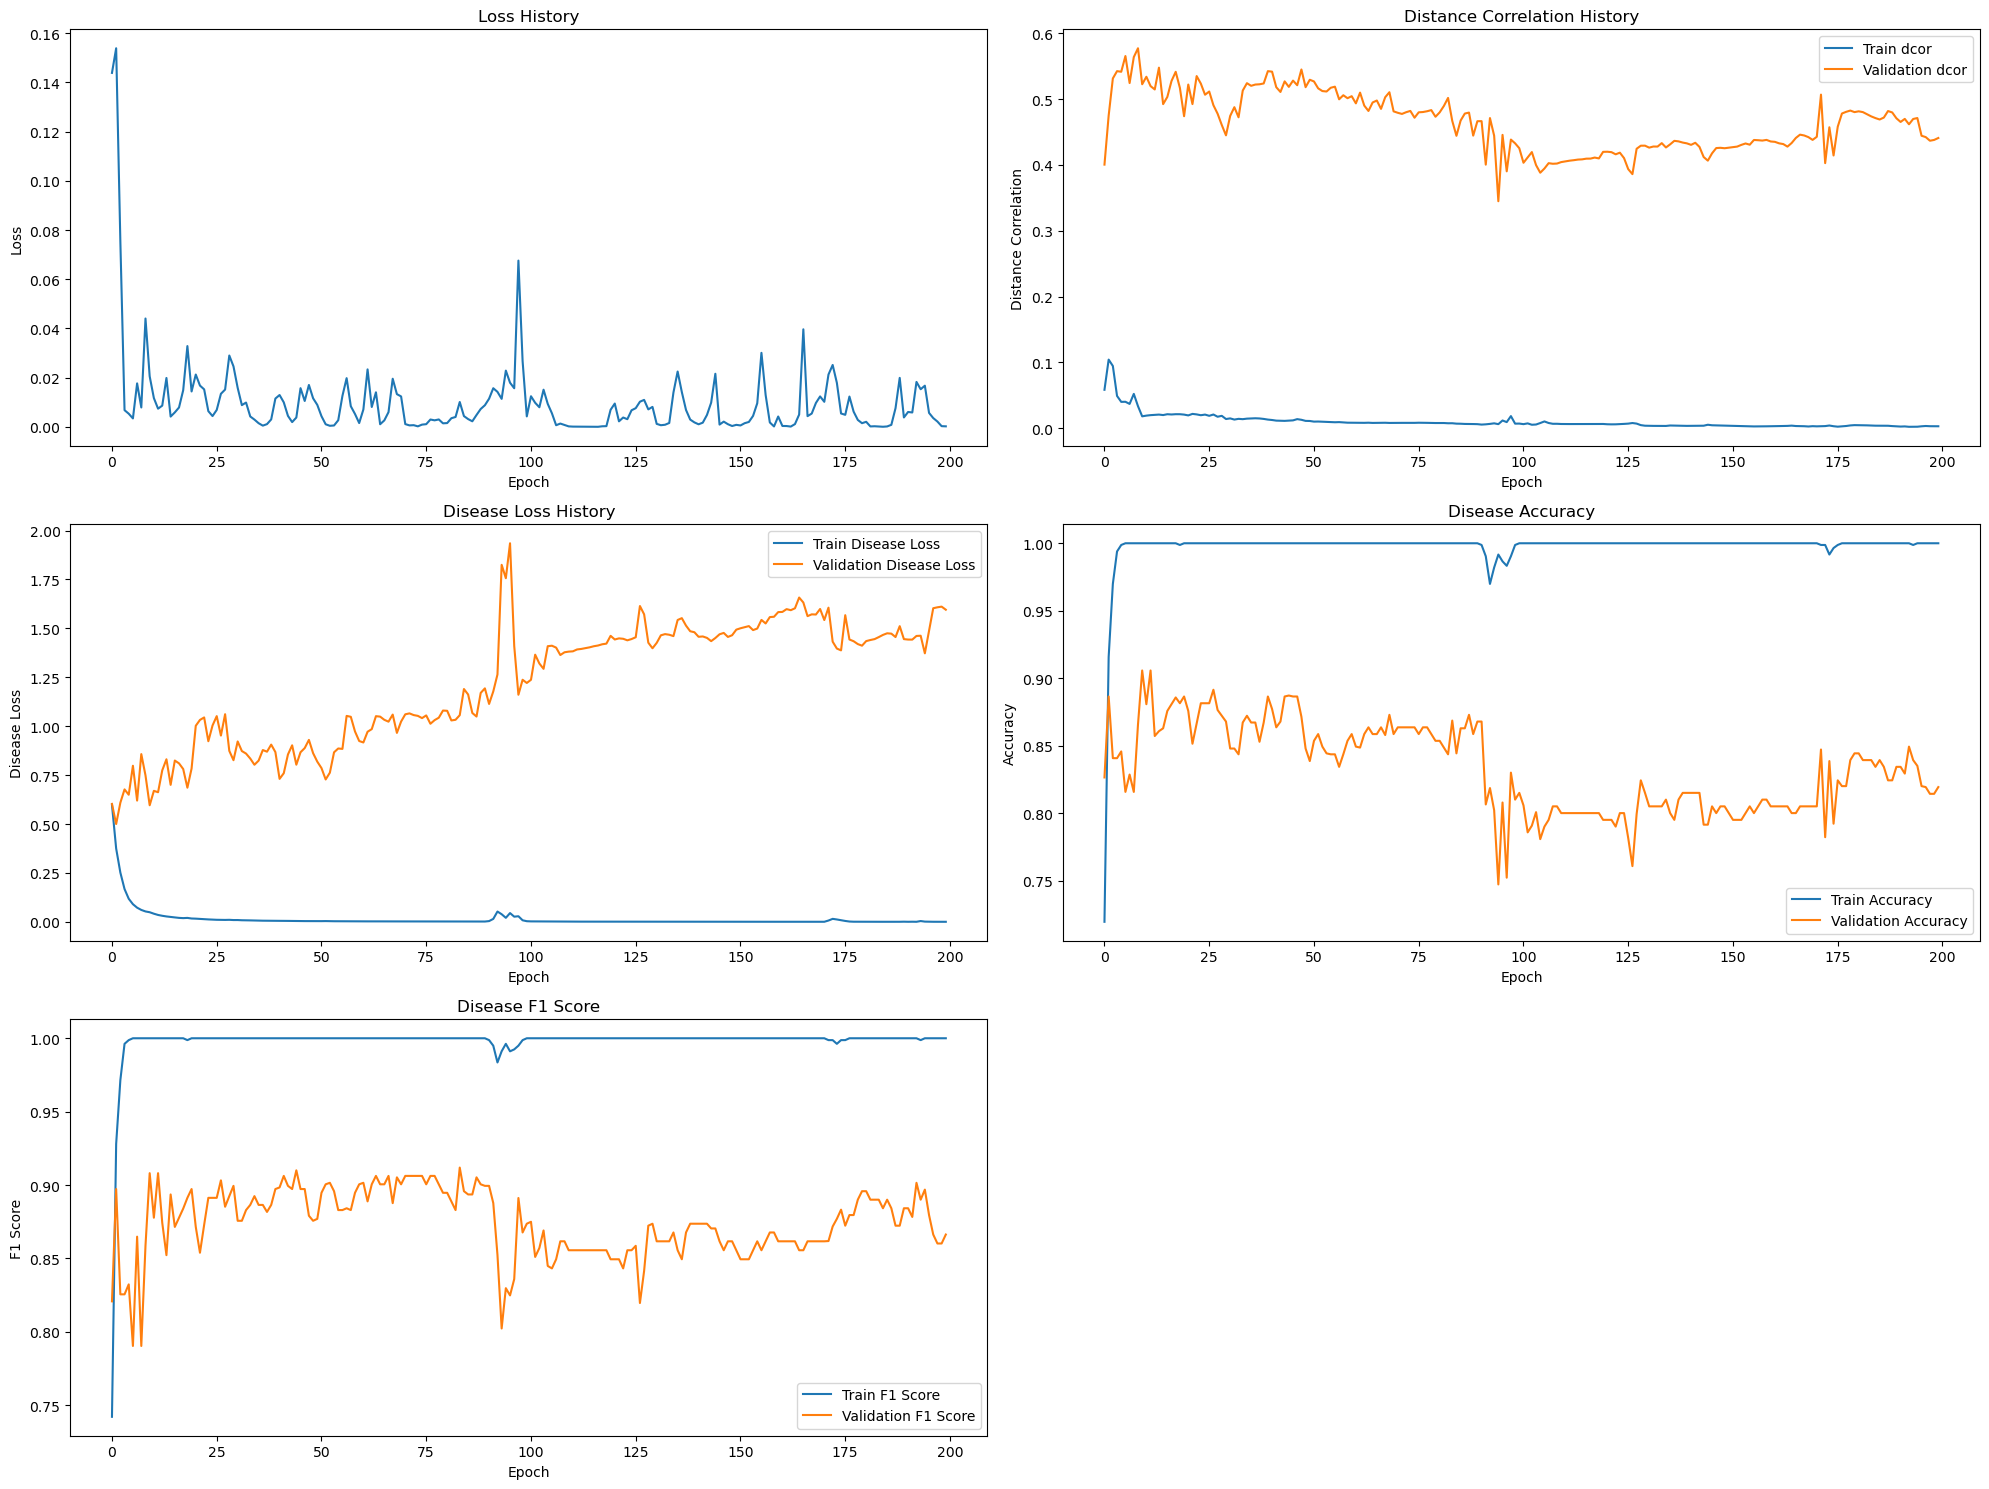

In [1]:
### data_all_loader has been added but not used yet
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import dcor
import math
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import train_test_split


# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pearson Correlation Loss
class PearsonCorrelationLoss(nn.Module):
    def __init__(self):
        super(PearsonCorrelationLoss, self).__init__()

    def forward(self, pred, target):
        x = target
        y = pred
        mx = torch.mean(x)
        my = torch.mean(y)
        xm = x - mx
        ym = y - my
        r_num = torch.sum(xm * ym)
        r_den = torch.sqrt(torch.sum(xm ** 2) * torch.sum(ym ** 2)) + 1e-5
        r = r_num / r_den
        r = torch.clamp(r, min=-1.0, max=1.0)
        return r ** 2

def previous_power_of_two(x):
    """Return the largest power of two less than or equal to x."""
    return 1 << (x - 1).bit_length() - 1

class GAN(nn.Module):
    def __init__(self, input_size, latent_dim=64, num_layers=1):
        super(GAN, self).__init__()
        
        self.encoder = self._build_encoder(input_size, latent_dim, num_layers)
        self.classifier = self._build_classifier(latent_dim, num_layers)
        self.disease_classifier = self._build_classifier(latent_dim, num_layers)

    
    def _build_encoder(self, input_size, latent_dim, num_layers):
        """Build the encoder network."""
        layers = []
        first_layer = previous_power_of_two(input_size)
        layers.extend([
            nn.Linear(input_size, first_layer),
            nn.BatchNorm1d(first_layer),
            nn.ReLU()
        ])
        current_dim = first_layer
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.ReLU()
            ])
            current_dim = current_dim // 2
        layers.extend([
            nn.Linear(current_dim, latent_dim),
            nn.BatchNorm1d(latent_dim),
            nn.ReLU()
        ])
        return nn.Sequential(*layers)

    def _build_classifier(self, latent_dim, num_layers):
        """Build the disease classifier."""
        layers = []
        current_dim = latent_dim
        for _ in range(num_layers):
            layers.extend([
                nn.Linear(current_dim, current_dim // 2),
                nn.BatchNorm1d(current_dim // 2),
                nn.Tanh()
            ])
            current_dim = current_dim // 2
        layers.append(nn.Linear(current_dim, 1))
        # layers.append(nn.Sigmoid())
        return nn.Sequential(*layers)
    
    

def load_and_transform_data(file_path):
    """
    Load data from CSV, apply CLR transformation, and return transformed DataFrame with 'uid'.
    """
    data = pd.read_csv(file_path)
    uid = data['SampleID']
    X = data.drop(columns=['SampleID']).values
    X_log = np.log(X + 1)
    X_log_df = pd.DataFrame(X_log, columns=data.columns[1:])
    X_log_df['SampleID'] = uid
    return X_log_df[['SampleID'] + list(X_log_df.columns[:-1])]

def split_data_and_generate_tensors():
    file_path = 'MetaCardis_data/train_T2D_abundance.csv'
    metadata_file_path = 'MetaCardis_data/train_T2D_metadata.csv'
    
    # Load data
    relative_abundance = load_and_transform_data(file_path)
    metadata = pd.read_csv(metadata_file_path)
    
    # Merge data
    merged_data = pd.merge(metadata, relative_abundance, on='SampleID')
    
    # Split data into training and validation sets with stratification
    train_data, val_data = train_test_split(
        merged_data, 
        test_size=0.2, 
        stratify=merged_data['PATGROUPFINAL_C'], 
        random_state=42
    )
    
    # Apply generate_all_data logic to training data
    metadata_columns = metadata.columns.tolist()
    feature_columns = [col for col in merged_data.columns if col not in metadata_columns and col != 'SampleID']
    
    # Training data tensors
    x_train_all = torch.tensor(train_data[feature_columns].values, dtype=torch.float32)
    y_train_all = torch.tensor(train_data['PATGROUPFINAL_C'].values, dtype=torch.float32).unsqueeze(1)
    
    # Validation data tensors
    x_val_all = torch.tensor(val_data[feature_columns].values, dtype=torch.float32)
    y_val_all = torch.tensor(val_data['PATGROUPFINAL_C'].values, dtype=torch.float32).unsqueeze(1)
    
    # Apply generate_disease_data logic to filtered training data
    filtered_train_data = train_data[train_data['PATGROUPFINAL_C'] == 1]
    x_train_disease = torch.tensor(filtered_train_data[feature_columns].values, dtype=torch.float32)
    y_train_disease = torch.tensor(filtered_train_data['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)
    
    # Apply generate_disease_data logic to filtered validation data
    filtered_val_data = val_data[val_data['PATGROUPFINAL_C'] == 1]
    x_val_disease = torch.tensor(filtered_val_data[feature_columns].values, dtype=torch.float32)
    y_val_disease = torch.tensor(filtered_val_data['METFORMIN_C'].values, dtype=torch.float32).unsqueeze(1)
    
    return x_train_all, y_train_all, x_val_all, y_val_all, x_train_disease, y_train_disease, x_val_disease, y_val_disease
    


def create_balanced_dataloader(x_train, y_train, batch_size):
    labels = y_train.squeeze()
    unique_labels = labels.unique()
    num_classes = len(unique_labels)
    samples_per_class = batch_size // num_classes

    # Get indices for each class and shuffle them
    class_indices = {label.item(): (labels == label).nonzero(as_tuple=True)[0] for label in unique_labels}
    for label in class_indices:
        indices = class_indices[label]
        class_indices[label] = indices[torch.randperm(len(indices))]

    # Generate balanced batches
    def balanced_batches(class_indices, samples_per_class, batch_size):
        batches = []
        class_cursors = {label: 0 for label in class_indices}
        while True:
            batch = []
            for label in class_indices:
                cursor = class_cursors[label]
                indices = class_indices[label]
                remaining_samples = len(indices) - cursor
                if remaining_samples >= samples_per_class:
                    batch_indices = indices[cursor:cursor+samples_per_class]
                    batch.extend(batch_indices.tolist())
                    class_cursors[label] += samples_per_class
                else:
                    # Not enough samples to form another batch
                    return batches
            # Shuffle batch indices
            batch = torch.tensor(batch)[torch.randperm(len(batch))].tolist()
            batches.append(batch)
        return batches

    batches = balanced_batches(class_indices, samples_per_class, batch_size)

    # Create a custom BatchSampler
    class BalancedBatchSampler(torch.utils.data.BatchSampler):
        def __init__(self, batches):
            self.batches = batches

        def __iter__(self):
            for batch in self.batches:
                yield batch

        def __len__(self):
            return len(self.batches)

    # Create a dataset and a DataLoader with the custom BatchSampler
    dataset = TensorDataset(x_train, y_train)
    batch_sampler = BalancedBatchSampler(batches)
    data_loader = DataLoader(dataset, batch_sampler=batch_sampler)

    return data_loader




# New function to encapsulate class proportion and stratified batching logic
def create_stratified_dataloader(x_train, y_train, batch_size):
    # Compute class counts and proportions
    labels = y_train.squeeze()
    unique_labels = labels.unique()
    class_counts = {label.item(): (labels == label).sum().item() for label in unique_labels}
    total_samples = len(labels)
    class_proportions = {label: count / total_samples for label, count in class_counts.items()}

    # Compute samples per class per batch
    samples_per_class = {}
    remainders = {}
    total_samples_in_batch = 0

    for label, proportion in class_proportions.items():
        exact_samples = proportion * batch_size
        samples = int(math.floor(exact_samples))
        remainder = exact_samples - samples
        samples_per_class[label] = samples
        remainders[label] = remainder
        total_samples_in_batch += samples

    # Distribute remaining slots based on the largest remainders
    remaining_slots = batch_size - total_samples_in_batch
    sorted_labels = sorted(remainders.items(), key=lambda x: x[1], reverse=True)
    for i in range(remaining_slots):
        label = sorted_labels[i % len(sorted_labels)][0]
        samples_per_class[label] += 1

    # Get indices for each class and shuffle them
    class_indices = {label.item(): (labels == label).nonzero(as_tuple=True)[0] for label in unique_labels}
    for label in class_indices:
        indices = class_indices[label]
        class_indices[label] = indices[torch.randperm(len(indices))]

    # Generate stratified batches
    def stratified_batches(class_indices, samples_per_class, batch_size):
        batches = []
        class_cursors = {label: 0 for label in class_indices}
        num_samples = sum([len(indices) for indices in class_indices.values()])
        num_batches = math.ceil(num_samples / batch_size)

        for _ in range(num_batches):
            batch = []
            for label, indices in class_indices.items():
                cursor = class_cursors[label]
                samples = samples_per_class[label]
                # If we've run out of samples for this class, skip
                if cursor >= len(indices):
                    continue
                # Adjust samples if not enough samples left
                if cursor + samples > len(indices):
                    samples = len(indices) - cursor
                batch_indices = indices[cursor:cursor+samples]
                batch.extend(batch_indices.tolist())
                class_cursors[label] += samples
            # Shuffle batch indices
            if batch:
                batch = torch.tensor(batch)[torch.randperm(len(batch))].tolist()
                batches.append(batch)
        return batches

    batches = stratified_batches(class_indices, samples_per_class, batch_size)

    # Create a custom BatchSampler
    class StratifiedBatchSampler(torch.utils.data.BatchSampler):
        def __init__(self, batches):
            self.batches = batches

        def __iter__(self):
            for batch in self.batches:
                yield batch

        def __len__(self):
            return len(self.batches)

    # Create a dataset and a DataLoader with the custom BatchSampler
    dataset = TensorDataset(x_train, y_train)
    batch_sampler = StratifiedBatchSampler(batches)
    data_loader = DataLoader(dataset, batch_sampler=batch_sampler)

    return data_loader

# Training function with DataLoader
def train_model(model, criterion, optimizer, data_loader, data_all_loader, num_epochs, criterion_classifier, optimizer_classifier, criterion_disease_classifier, optimizer_disease_classifier, val_all_loader):
    
    disease_loss_history = []
    loss_history = []
    dcor_history = []
    dcor_val_history = []
    train_disease_accs = []
    train_disease_f1s = []
    val_disease_loss_history = []
    val_disease_accs = []
    val_disease_f1s = []

    model = model.to(device)
    criterion = criterion.to(device)
    criterion_classifier = criterion_classifier.to(device)
    criterion_disease_classifier = criterion_disease_classifier.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        
        epoch_loss = 0
        epoch_disease_loss = 0
        epoch_train_preds = []
        epoch_train_labels = []
        hidden_activations_list = []
        targets_list = []
        
        # Create iterators from both data_loaders
        data_iter = iter(data_loader)
        data_all_iter = iter(data_all_loader)
        
        while True:
            try:
                # Get the next batch from data_all_loader
                x_all_batch, y_all_batch = next(data_all_iter)
                x_all_batch, y_all_batch = x_all_batch.to(device), y_all_batch.to(device)
                
                # Try to get the next batch from data_loader
                try:
                    x_batch, y_batch = next(data_iter)
                except StopIteration:
                    # If data_loader is exhausted, re-initialize it
                    data_iter = iter(data_loader)
                    x_batch, y_batch = next(data_iter)
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                
                # ----------------------------
                # Train drug classification (r_loss) using x_batch, y_batch
                # ----------------------------
                # Freeze encoder parameters
                for param in model.encoder.parameters():
                    param.requires_grad = False

                encoded_features = model.encoder(x_batch)
                predicted_drug = model.classifier(encoded_features)
                r_loss = criterion_classifier(predicted_drug, y_batch)
                
                # Backward pass and optimization
                optimizer_classifier.zero_grad()
                r_loss.backward()
                optimizer_classifier.step()
                    
                # Unfreeze encoder parameters
                for param in model.encoder.parameters():
                    param.requires_grad = True

                # ----------------------------
                # Train distiller (g_loss) using x_batch, y_all_batch
                # ----------------------------
                # Freeze classifier parameters
                for param in model.classifier.parameters():
                    param.requires_grad = False
                
                encoded_features = model.encoder(x_batch)
                predicted_d = model.classifier(encoded_features)
                predicted_drug= torch.sigmoid(predicted_d)
                g_loss = criterion(predicted_drug, y_batch)
                
                # Collect hidden activations and targets
                hidden_activations_list.append(encoded_features.detach().cpu())
                targets_list.append(y_batch.detach().cpu())
        
                # Backward pass and optimization
                optimizer.zero_grad()
                g_loss.backward()
                optimizer.step()
        
                epoch_loss += g_loss.item()
                
                # Unfreeze classifier parameters
                for param in model.classifier.parameters():
                    param.requires_grad = True

                # ----------------------------
                # Train encoder & classifier (c_loss)
                # ----------------------------

                encoded_features_all = model.encoder(x_all_batch)
                predicted_disease_all = model.disease_classifier(encoded_features_all)
                c_loss = criterion_disease_classifier(predicted_disease_all, y_all_batch)
                
                # Backward pass and optimization
                optimizer_disease_classifier.zero_grad()
                c_loss.backward()
                optimizer_disease_classifier.step()

                epoch_disease_loss += c_loss.item()

                pred_tag = (torch.sigmoid(predicted_disease_all) > 0.5).float()
                epoch_train_preds.append(pred_tag.cpu())
                epoch_train_labels.append(y_all_batch.cpu())

            except StopIteration:
                # When the data_all_loader iterator is exhausted, break the loop
                break

        # After the epoch, compute metrics or perform validation as needed
        avg_loss = epoch_loss / len(data_all_loader)
        avg_disease_loss = epoch_disease_loss/len(data_all_loader)
        loss_history.append(avg_loss)
        disease_loss_history.append(avg_disease_loss)

        epoch_train_preds = torch.cat(epoch_train_preds)
        epoch_train_labels = torch.cat(epoch_train_labels)

        train_disease_acc = balanced_accuracy_score(epoch_train_labels, epoch_train_preds)
        train_disease_accs.append(train_disease_acc)
        train_disease_f1 = f1_score(epoch_train_labels, epoch_train_preds)
        train_disease_f1s.append(train_disease_f1)
        
        # Concatenate hidden activations and targets
        hidden_activations_all = torch.cat(hidden_activations_list, dim=0)
        targets_all = torch.cat(targets_list, dim=0)
    
        # Compute distance correlation between hidden activations and targets
        hidden_activations_np = hidden_activations_all.numpy()
        targets_np = targets_all.numpy()
        dcor_value = dcor.distance_correlation_sqr(hidden_activations_np, targets_np)
        dcor_history.append(dcor_value)

        # ----------------------------
        # Validation Phase
        # ----------------------------
        model.eval()
        with torch.no_grad():
            val_epoch_loss = 0
            val_epoch_preds = []
            val_epoch_labels = []
            hidden_activations_val_list = []
            targets_val_list = []
            for x_val_batch, y_val_batch in val_all_loader:
                x_val_batch, y_val_batch = x_val_batch.to(device), y_val_batch.to(device)
                encoded_features_val = model.encoder(x_val_batch)
                predicted_disease_val = model.disease_classifier(encoded_features_val)
                c_loss_val = criterion_disease_classifier(predicted_disease_val, y_val_batch)
                val_epoch_loss += c_loss_val.item()
                pred_val_tag = (torch.sigmoid(predicted_disease_val) > 0.5).float()
                val_epoch_preds.append(pred_val_tag.cpu())
                val_epoch_labels.append(y_val_batch.cpu())

                # Collect hidden activations and targets for dcor calculation
                hidden_activations_val_list.append(encoded_features_val.cpu())
                targets_val_list.append(y_val_batch.cpu())

            avg_val_loss = val_epoch_loss / len(val_all_loader)
            val_epoch_preds = torch.cat(val_epoch_preds)
            val_epoch_labels = torch.cat(val_epoch_labels)

            val_disease_acc = balanced_accuracy_score(val_epoch_labels, val_epoch_preds)
            val_disease_accs.append(val_disease_acc)
            val_disease_f1 = f1_score(val_epoch_labels, val_epoch_preds)
            val_disease_f1s.append(val_disease_f1)
            val_disease_loss_history.append(avg_val_loss)

            # Compute distance correlation for validation data
            hidden_activations_val_all = torch.cat(hidden_activations_val_list, dim=0)
            targets_val_all = torch.cat(targets_val_list, dim=0)

            hidden_activations_val_np = hidden_activations_val_all.numpy()
            targets_val_np = targets_val_all.numpy()
            dcor_value_val = dcor.distance_correlation_sqr(hidden_activations_val_np, targets_val_np)
            dcor_val_history.append(dcor_value_val)
        
        if (epoch+1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, DCor: {dcor_value:.4f}')
    
    return (loss_history, dcor_history, disease_loss_history, train_disease_accs, train_disease_f1s,
            dcor_val_history, val_disease_loss_history, val_disease_accs, val_disease_f1s)

    # return (disease_loss_history, train_disease_accs, train_disease_f1s,
    #         val_disease_loss_history, val_disease_accs, val_disease_f1s)


# Weight initialization function
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.BatchNorm1d):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)

# Main
if __name__ == "__main__":
    # Hyperparameters
    input_size = 654  # 654 features
    latent_dim = 64
    num_layers = 1
    learning_rate = 0.001
    num_epochs = 200
    batch_size = 64

    # Generate synthetic data with 654 features and imbalanced labels
    
    x_all_train, y_all_train, x_all_val, y_all_val, x_train, y_train, x_val_train, y_val_train= split_data_and_generate_tensors()

    # Create stratified DataLoader
    data_loader = create_stratified_dataloader(x_train, y_train, batch_size)
    data_all_loader = create_stratified_dataloader(x_all_train, y_all_train, batch_size)
    val_all_loader = create_stratified_dataloader(x_all_val, y_all_val, batch_size)

    # Define model, loss, and optimizer
    model = GAN(input_size, latent_dim=latent_dim, num_layers=num_layers).to(device)
    criterion = PearsonCorrelationLoss().to(device)  # Use correlation loss
    optimizer = optim.Adam(model.encoder.parameters(), lr=learning_rate)
    criterion_classifier = nn.BCEWithLogitsLoss().to(device)  # Use binary cross-entropy loss for classification
    optimizer_classifier = optim.Adam(model.classifier.parameters(), lr=learning_rate)
    criterion_disease_classifier = nn.BCEWithLogitsLoss().to(device)
    optimizer_disease_classifier = optim.Adam(list(model.encoder.parameters()) + list(model.disease_classifier.parameters()), lr=learning_rate)

    # Move model and criteria to device
    model = model.to(device)
    # Apply weight initialization
    # model.apply(init_weights)

    criterion = criterion.to(device)
    criterion_classifier = criterion_classifier.to(device)
    criterion_disease_classifier = criterion_disease_classifier.to(device)

# Train the model
loss_history, dcor_history, disease_loss_history, train_disease_accs, train_disease_f1s, dcor_val_history, val_disease_loss_history, val_disease_accs, val_disease_f1s = train_model(
    model, criterion, optimizer, data_loader, data_all_loader, num_epochs, 
    criterion_classifier, optimizer_classifier, criterion_disease_classifier, optimizer_disease_classifier, val_all_loader
)

# disease_loss_history, train_disease_accs, train_disease_f1s, val_disease_loss_history, val_disease_accs, val_disease_f1s = train_model(
#     model, criterion, optimizer, data_loader, data_all_loader, num_epochs, 
#     criterion_classifier, optimizer_classifier, criterion_disease_classifier, optimizer_disease_classifier, val_all_loader
# )

# Plot the loss history, distance correlation history, disease loss history, training accuracy, and F1 score
plt.figure(figsize=(20, 15))

# First row: Loss and Distance Correlation
plt.subplot(3, 2, 1)
plt.plot(loss_history)
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(3, 2, 2)
plt.plot(dcor_history, label='Train dcor')
plt.plot(dcor_val_history, label = 'Validation dcor')
plt.title("Distance Correlation History")
plt.xlabel("Epoch")
plt.ylabel("Distance Correlation")
plt.legend()

# Second row: Disease Loss History (Training and Validation)
plt.subplot(3, 2, 3)
plt.plot(disease_loss_history, label='Train Disease Loss')
plt.plot(val_disease_loss_history, label='Validation Disease Loss')
plt.title("Disease Loss History")
plt.xlabel("Epoch")
plt.ylabel("Disease Loss")
plt.legend()

# Third row: Disease Accuracy (Training and Validation)
plt.subplot(3, 2, 4)
plt.plot(train_disease_accs, label='Train Accuracy')
plt.plot(val_disease_accs, label='Validation Accuracy')
plt.title("Disease Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# Third row: Disease F1 Score (Training and Validation)
plt.subplot(3, 2, 5)
plt.plot(train_disease_f1s, label='Train F1 Score')
plt.plot(val_disease_f1s, label='Validation F1 Score')
plt.title("Disease F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
def count_labels_in_loader(data_loader):
    num_ones = 0
    num_zeros = 0

    for _, y_batch in data_loader:
        # Ensure y_batch is on CPU for consistency
        y_batch = y_batch.cpu()
        num_ones += (y_batch == 1).sum().item()
        num_zeros += (y_batch == 0).sum().item()

    return num_ones, num_zeros

# Use the function for your validation DataLoader
num_ones_val, num_zeros_val = count_labels_in_loader(data_loader)
print(f'Validation Data: Number of Ones: {num_ones_val}, Number of Zeros: {num_zeros_val}')


Validation Data: Number of Ones: 96, Number of Zeros: 96
